# Develop

Some basics of Keras and tensorflow I have learned with the help of these notebooks by: [siimondele](https://www.kaggle.com/sdelecourt/cnn-with-keras), [Francesco Marazzi](https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb)

In [0]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow import keras

import tensorflow as tf
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import os
from sklearn.model_selection import cross_val_score
import zipfile
from google.colab import files

### Define Data class

In [0]:
class Data:
    """ 
    This class creates dataframes containing ID and the label, if it exists 
    for the train, validation, and test sets. The IDs for the tets set need to 
    be found by looking at the names in the test folder. It then makes tensorflow 
    image generators by flowing from the dataframes that can be used to fit a model. 
    """

    def __init__(self, train_path, train_labels_path, test_path, unique_identifier, target_class_column):
        self.train_path = train_path
        self.train_labels_path = train_labels_path
        self.test_path = test_path
    
        self.train_data_gen = ImageDataGenerator(validation_split = 0.2, 
                                                 # Fraction of images reserved for validation
                                                rescale = 1./255,  # Normalize
                                                horizontal_flip = True, # Randomly flip the orientations for training
                                                vertical_flip = True)
        self.test_data_gen = ImageDataGenerator(rescale = 1./255,
                                                horizontal_flip = True,
                                                vertical_flip = True)

        self.image_size = (96, 96)
        self.n_channels = 3
        self.unique_identifier = 'id'
        self.target_class_column = 'label'
        
        self.train_df = self._create_train_df(self.train_labels_path)

        self.train_df = self.train_df.head(20)
        self.test_df = self._create_test_df(self.test_path)
        self._create_data_generators()
        
    def _create_train_df(self, train_labels_path):
        train_df = self._load_target_labels(train_labels_path)
        train_df['id'] = train_df['id'].apply(lambda x: x+".tif")
        return train_df.astype({'label': 'str'})

    def _create_test_df(self, test_path):
        filenames =[]
        for dirname, _, filename in os.walk(test_path):
            filenames.extend(filename)
        return pd.DataFrame({"id":filenames})

    def _create_data_generators(self):
        pars = {'dataframe': self.train_df, 
                'directory': self.train_path, 
                'x_col': self.unique_identifier, # filenames of images
                'y_col': self.target_class_column, # class
                'target_size': self.image_size,
                'class_mode':'binary', 
                'batch_size': 64} 

        self.train_generator = self.train_data_gen.flow_from_dataframe(**pars, subset = 'training') 
        self.validation_generator = self.train_data_gen.flow_from_dataframe(**pars, 
                                                                            subset = 'validation', 
                                                                            shuffle = False)
                     # Don't shuffle the validation set, metrics will be evaluated 
                     # on the whole set at each epoch, and we want it in a set order 
                     # for predictions after training.
                                                        
        self.test_generator = self.test_data_gen.flow_from_dataframe(dataframe = self.test_df,
                                                    directory = test_path,
                                                    x_col = self.unique_identifier, # filename 
                                                    class_mode = None,
                                                    target_size = self.image_size,
                                                    batch_size = 1,
                                                    shuffle = False) # Don't want to shuffle the test data
    def _load_target_labels(self, filename):
        return pd.read_csv(filename)

### Define Model Container class:

In [0]:
class ModelContainer:
    """
    This class holds various models and may be used to train them and make 
    predictions on a data set. It will select the best model based on the AUC of 
    predictions on the validation set.
    """

    def __init__(self, models=[]):
        self.models = {}
        [self.add_model(model) for model in models]

        self.models_path = 'models'
        os.makedirs(self.models_path, exist_ok = True)

        self.best_model_name = None
        self.predictions = None
        self.roc_auc = {}
        self.val_roc_auc = {} # Validation set
    
    def add_model(self, model):
        self.models[model.name] = model
    
    def train_model(self, data, model_name):
       
        model = self.models[model_name]

        checkpoint_cb = keras.callbacks.ModelCheckpoint(os.path.join(self.models_path, model_name + ".h5"))
        early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True, verbose = 1)
        
        # Reduce learning rate on plateaus:
        reduce_LR_cb = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience = 10, verbose = 1, factor = 0.1)

        history = model.fit(data.train_generator, 
                            epochs = 15, 
                            validation_data = (data.validation_generator), 
                            #use_multiprocessing=True,
                            callbacks = [checkpoint_cb, reduce_LR_cb, early_stopping_cb])

        # For some reason the names of these keys change for multiple runs of the 
        # training procedure:
        self.roc_auc[model.name] = history.history[list(history.history.keys())[1]][-1] # 'auc'
        self.val_roc_auc[model.name] = history.history[list(history.history.keys())[3]][-1] # 'val_auc'

    def save_model(self, model_name):
        # Save to model to file:
        path_to_model = os.path.join(self.models_path, model_name + ".h5")
        self.models[model_name].save(path_to_model)
        # For use with colab, download the file:
        files.download(path_to_model)
        
    def select_best_model(self):
        # Selects and saves the best model based based on AUC on validation set:
        self.best_model_name = max(self.val_roc_auc, key = self.val_roc_auc.get)

    def best_model_predict(self, data_gen):
        self.predictions = self.models[self.best_model_name].predict(data_gen, verbose = 1)
    
    def print_summary(self):
        print('\nModel Summaries:\n')
        for model_name in self.models.keys():
            print('\n', model_name, '- ROC AUC:', models.roc_auc[model_name])
            print('\n', model_name, '- Validation ROC AUC:', models.val_roc_auc[model_name])

        print('\nBest Model:\n', self.best_model_name)
        print('\nROC AUC of Best Model\n', models.roc_auc[self.best_model_name])


### Define parameters for this project & download the data from Kaggle:

In [6]:
# Use this to upload the kaggle.json from your local machine:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [8]:
!cp kaggle.json '/root/.kaggle/'
!chmod 600 '/root/.kaggle/kaggle.json'
!kaggle config set -n path -v '/content/'
!kaggle competitions download histopathologic-cancer-detection

- path is now set to: /content/
  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 97.4MB/s]
  0% 0.00/5.10M [00:00<?, ?B/s]
100% 5.10M/5.10M [00:00<00:00, 47.1MB/s]
100% 1.30G/1.30G [00:16<00:00, 83.3MB/s]
100% 1.30G/1.30G [00:16<00:00, 84.2MB/s]
100% 4.97G/4.98G [00:59<00:00, 142MB/s]
100% 4.98G/4.98G [00:59<00:00, 89.3MB/s]


In [0]:
root_dir = '/content/competitions/histopathologic-cancer-detection/'
train_path = os.path.join(root_dir, 'train/')
test_path = os.path.join(root_dir, 'test/')
models_path = os.path.join(root_dir, 'models/')

train_labels_path = os.path.join(root_dir, 'train_labels.csv/train_labels.csv')

unique_identifier = 'id'
target_class_column = 'label'

In [0]:
# Unzip files in all zipped directories:
os.chdir(root_dir)

for path_to_zip_file in os.listdir():
    new_directory = os.path.splitext(path_to_zip_file)[0]
    os.makedirs(new_directory, exist_ok = True)
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
      zip_ref.extractall(new_directory)
      zip_ref.close()

In [11]:
os.chdir(root_dir)
! ls -l | head -10

total 6617100
drwxr-xr-x 2 root root       4096 Nov  1 16:07 sample_submission.csv
-rw-r--r-- 1 root root    1394488 Nov  1 16:02 sample_submission.csv.zip
drwxr-xr-x 2 root root    4378624 Nov  1 16:08 test
-rw-r--r-- 1 root root 1401100547 Nov  1 16:03 test.zip
drwxr-xr-x 2 root root   16695296 Nov  1 16:07 train
drwxr-xr-x 2 root root       4096 Nov  1 16:06 train_labels.csv
-rw-r--r-- 1 root root    5352900 Nov  1 16:02 train_labels.csv.zip
-rw-r--r-- 1 root root 5346961539 Nov  1 16:04 train.zip


## Prepare the data for modelling:

In [62]:
data = Data(train_path, train_labels_path, test_path, unique_identifier, target_class_column)

Found 16 validated image filenames belonging to 2 classes.
Found 4 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.


## Make a baseline model:

In [0]:
baseline_layers = [
    keras.layers.Conv2D(filters = 64 , kernel_size = 7, activation = "relu", padding = "valid", input_shape = [data.image_size[0], data.image_size[1], data.n_channels]), 
    keras.layers.MaxPooling2D(pool_size = 2), 
    keras.layers.Conv2D(128, 3, activation = "relu", padding = "same"), 
    keras.layers.Conv2D(128, 3 , activation = "relu" , padding = "same"), 
    keras.layers.MaxPooling2D(2), 
    keras.layers.Conv2D(256, 3 , activation = "relu" , padding = "same"), 
    keras.layers.Conv2D(256, 3 , activation = "relu" , padding = "same"),   
    keras.layers.MaxPooling2D(2), 
    keras.layers.Flatten(), 
    keras.layers.Dense(128, activation = "relu"), 
    keras.layers.Dropout(0.5), 
    keras.layers.Dense(64, activation = "relu"), 
    keras.layers.Dropout(0.5), 
    keras.layers.Dense(1, activation = "sigmoid")
] 
baseline_model = keras.models.Sequential(baseline_layers, name = 'baseline')
#baseline_model_adaptive = keras.models.Sequential(baseline_layers, name = 'baseline_adaptive')

baseline_model.compile(loss = keras.losses.binary_crossentropy, 
                       optimizer = keras.optimizers.SGD(lr = 0.001), 
                       metrics = [tf.keras.metrics.AUC()])

# Use the Adam adaptive learning rate optimization algorithm:
#baseline_model_adaptive.compile(keras.optimizers.Adam(0.01), loss = keras.losses.binary_crossentropy, 
                       #optimizer = keras.optimizers.SGD(lr = 0.001), 
#                       metrics = [tf.keras.metrics.AUC()])


In [55]:
baseline_model.summary()

Model: "baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 90, 90, 64)        9472      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 45, 45, 128)       73856     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 45, 45, 128)       147584    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 22, 22, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 22, 22, 256)       295168    
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 22, 22, 256)       590

In [0]:
models = ModelContainer()
models.add_model(baseline_model)

In [107]:
models.train_model(data, 'baseline')

Epoch 1/15
Epoch 1/15
1/1 [==============================] - 0s 257ms/step - loss: 0.6657 - auc: 0.5500 - val_loss: 0.6194 - val_auc: 0.0000e+00
Epoch 2/15
Epoch 1/15
1/1 [==============================] - 0s 238ms/step - loss: 0.6537 - auc: 0.6333 - val_loss: 0.6150 - val_auc: 0.3333
Epoch 3/15
Epoch 1/15
1/1 [==============================] - 0s 237ms/step - loss: 0.6650 - auc: 0.5333 - val_loss: 0.6180 - val_auc: 0.3333
Epoch 4/15
Epoch 1/15
1/1 [==============================] - 0s 236ms/step - loss: 0.6544 - auc: 0.5417 - val_loss: 0.6204 - val_auc: 0.0000e+00
Epoch 5/15
Epoch 1/15
1/1 [==============================] - 0s 247ms/step - loss: 0.6631 - auc: 0.5083 - val_loss: 0.6211 - val_auc: 0.0000e+00
Epoch 6/15
Epoch 1/15
1/1 [==============================] - 0s 321ms/step - loss: 0.6651 - auc: 0.4583 - val_loss: 0.6206 - val_auc: 0.0000e+00
Epoch 7/15
Epoch 1/15
1/1 [==============================] - 0s 237ms/step - loss: 0.6473 - auc: 0.6083 - val_loss: 0.6189 - val_auc: 0.00

In [0]:
models.save_model('baseline')

### Let's see how Marazzi's model compares to the baseline:

In [0]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

marazzi_layers = [
    keras.layers.Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = [data.image_size[0], data.image_size[1], data.n_channels]),
    keras.layers.Conv2D(first_filters, kernel_size, use_bias = False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPool2D(pool_size = pool_size),
    keras.layers.Dropout(dropout_conv),

    keras.layers.Conv2D(second_filters, kernel_size, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Conv2D(second_filters, kernel_size, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPool2D(pool_size = pool_size),
    keras.layers.Dropout(dropout_conv),

    keras.layers.Conv2D(third_filters, kernel_size, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Conv2D(third_filters, kernel_size, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPool2D(pool_size = pool_size),
    keras.layers.Dropout(dropout_conv),

    keras.layers.Flatten(),
    keras.layers.Dense(256, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dropout(dropout_dense),
    keras.layers.Dense(1, activation = "sigmoid"),
]
marazzi_model = keras.models.Sequential(marazzi_layers, name = 'marazzi')

marazzi_model.compile(keras.optimizers.Adam(0.01), 
                      loss = keras.losses.binary_crossentropy, 
                      # optimizer = keras.optimizers.SGD(lr = 0.001), 
                       metrics = ['accuracy']) #[tf.keras.metrics.AUC()])


In [65]:
marazzi_model.summary()

Model: "marazzi"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_18 (Batc (None, 92, 92, 32)        128       
_________________________________________________________________
activation_18 (Activation)   (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 44, 44, 64)        1843

* His model has a lot less parameters than the baseline model (~2 million compared to ~5 million)

In [0]:
models.add_model(marazzi_model)

In [81]:
models.train_model(data, 'marazzi')

Epoch 1/15
Epoch 1/15
1/1 [==============================] - 0s 320ms/step - loss: 0.7582 - acc: 0.6250 - val_loss: 0.5843 - val_acc: 0.7500
Epoch 2/15
Epoch 1/15
1/1 [==============================] - 0s 303ms/step - loss: 0.4426 - acc: 0.7500 - val_loss: 0.5782 - val_acc: 0.7500
Epoch 3/15
Epoch 1/15
1/1 [==============================] - 0s 339ms/step - loss: 0.7071 - acc: 0.7500 - val_loss: 0.6162 - val_acc: 0.7500
Epoch 4/15
Epoch 1/15
1/1 [==============================] - 0s 315ms/step - loss: 0.2465 - acc: 0.8750 - val_loss: 0.6255 - val_acc: 0.7500
Epoch 5/15
Epoch 1/15
1/1 [==============================] - 0s 310ms/step - loss: 0.3087 - acc: 0.8750 - val_loss: 0.6112 - val_acc: 0.7500
Epoch 6/15
Epoch 1/15
1/1 [==============================] - 0s 330ms/step - loss: 0.3045 - acc: 0.8750 - val_loss: 0.6393 - val_acc: 0.7500
Epoch 7/15
Epoch 1/15
1/1 [==============================] - 0s 287ms/step - loss: 0.1885 - acc: 0.9375 - val_loss: 0.6257 - val_acc: 0.7500
Epoch 8/15
Ep

In [0]:
models.save_model('marazzi')

## Select best model:


In [82]:
models.select_best_model()
models.best_model_name


'baseline'

In [83]:
models.print_summary()


Model Summaries:


 baseline - ROC AUC: 0.5

 baseline - Validation ROC AUC: 0.16666666

 marazzi - ROC AUC: 0.9375

 marazzi - Validation ROC AUC: 0.75

Best Model:
 baseline

ROC AUC of Best Model
 0.5


In [92]:
models.best_model_predict(data.validation_generator)

1/1 [==============================] - 0s 11ms/step


This plot is courtesy of [Francesco Marazzi](https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb):

In [98]:
# Calc AUC of best model on validation set:
false_pos_rate, true_pos_rate, thresholds_keras = roc_curve(data.validation_generator.classes, models.predictions)
auc_best = auc(false_pos_rate, true_pos_rate)
auc_best

0.33333333333333337

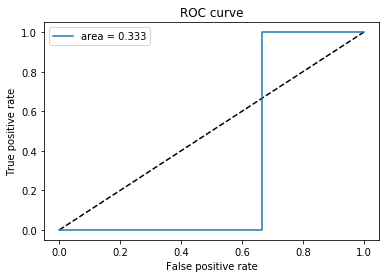

In [100]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_pos_rate, true_pos_rate, label='area = {:.3f}'.format(auc_best))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Submission to Kaggle:

In [0]:
models.best_model_predict(data.test_generator)

In [0]:
# Predictions were made in the order of the test_df using the test generator:
submission = data.test_df
submission['label'] = models.predictions
# Take out the extension for the submission:
submission['id'] = submission['id'].apply(lambda x: x.split(".")[0])

submission.to_csv("submission.csv", index = False, header = True)


In [0]:
submission.head()

,id,label
0,5d8721415d9480961c2d72e63343a64c7f656048,0.075276
1,9527fb2270fe6e386db403ab2a921d2e57ae2d02,0.122981
2,1ae9525a90929a70ce0c91e2d76ad8b9d5fb7c4a,0.064698
3,e812221e6331fc3ba9809c3f86db3579253bc2ab,0.611433
4,c1cc4da4d3e111f63959b1c984ecbb0806879099,0.070948


In [0]:
files.download("submission.csv")

In [94]:
!kaggle competitions submit -c histopathologic-cancer-detection -f submission.csv -m "Message"

100% 2.84M/2.84M [00:12<00:00, 247kB/s]
Successfully submitted to Histopathologic Cancer Detection